In [8]:
!pip install tensorflow nltk


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Embedding,  BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

import warnings
warnings.filterwarnings('ignore')


In [39]:
#Loading the dataset

In [10]:
data = pd.read_csv('/Amazon-Product-Review-Sentiment-Analysis-using-RNN-Dataset.csv')

# Printing shape of the dataset
print(data.shape)
# printing columns and rows information
print(data.info())


(25000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     24999 non-null  object
 1   Sentiment  25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB
None


In [ ]:
#Exploratory Data Analysis

In [11]:
# looking for NULL values
print("Null Values:\n", data.isna().sum())

# dropping null values
data = data.dropna()

# again checking for NULL values
print("Null Values after dropping:\n", data.isna().sum())


Null Values:
 Review       1
Sentiment    0
dtype: int64
Null Values after dropping:
 Review       0
Sentiment    0
dtype: int64


In [12]:
# count of unique values in Sentiment column
data['Sentiment'].value_counts()


,count
Sentiment,
1,5000
2,5000
3,5000
4,5000
5,4999


In [19]:
# downloading stopwords from nltk library
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# downloading punkt sentence tokenizer models
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
#Text Cleaning

In [20]:
# Review text Cleaning
def clean_reviews(text):

    # removing html brackets and other square brackets from the string using regex
    regex = re.compile('<.*?>') # r'<.*?>'
    text = re.sub(regex, '', text)

    # removing special characters like @, #, $, etc
    pattern = re.compile('[^a-zA-z0-9\s]')
    text = re.sub(pattern,'',text)

    # removing numbers
    pattern = re.compile('\d+')
    text = re.sub(pattern,'',text)

    # converting text to lower case
    text = text.lower()

In [22]:
from nltk.tokenize import word_tokenize

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = word_tokenize(text)  # Tokenize the text
    return text


In [ ]:
#Tokenization & Text Encoding:

In [23]:
tokenizer = Tokenizer()

# converting all the reviews to list to pass it as a parameter to fit_on_texts
reviews_to_list = data['Review'].tolist()
tokenizer.fit_on_texts(reviews_to_list)

# Generating text sequences
text_sequences = tokenizer.texts_to_sequences(reviews_to_list)

# setting maximum words we want in an example
max_words = 500

# Padding sequences
# - Before converting to a NumPy array, pad the sequences to ensure they all have the same length.
padded_sequences = pad_sequences(text_sequences, maxlen=max_words) # Use the same max_words value

text_sequences = np.array(padded_sequences)

# one hot encoding
data = pd.get_dummies(data, columns = ['Sentiment'])


# Generatin our X (input) to the model
# using pad_sequences and y (output)
X = pad_sequences(text_sequences, maxlen = max_words)
y = data[['Sentiment_1', 'Sentiment_2', 'Sentiment_3', 'Sentiment_4',
    'Sentiment_5']]
print(X.shape, y.shape)

# This code is modified by Susobhan Akhuli


(24999, 500) (24999, 5)


In [ ]:
#Train-Test Split:

In [24]:
# Train Test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(19999, 500) (5000, 500) (19999, 5) (5000, 5)


In [ ]:
#Model Building, Compiling andLet’s Training

In [25]:
# Creating a RNN model
rnn = Sequential(name="Simple_RNN")
rnn.add(Embedding(len(tokenizer.word_index)+1,
                        max_words,
                        input_length=max_words))

rnn.add(SimpleRNN(128,activation='relu',return_sequences=True))

rnn.add(SimpleRNN(64,activation='relu',return_sequences=False))

rnn.add(Dense(5, activation='softmax'))

# printing model summary
print(rnn.summary())


Model: "Simple_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#Compiling the model and Model Evaluation

In [26]:
# Compiling model
rnn.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the model
history = rnn.fit(X_train, y_train,
                        batch_size=64,
                        epochs=2,
                        verbose=1,
                          validation_data = (X_test, y_test))

# Printing model score on test data
print("Simple_RNN Score---> ", rnn.evaluate(X_test, y_test, verbose=1))


Epoch 1/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 279s 876ms/step - accuracy: 0.3000 - loss: 1.5058 - val_accuracy: 0.4308 - val_loss: 1.2713
Epoch 2/2
313/313 ━━━━━━━━━━━━━━━━━━━━ 335s 917ms/step - accuracy: 0.5013 - loss: 1.1685 - val_accuracy: 0.4586 - val_loss: 1.2299
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.4535 - loss: 1.2377
Simple_RNN Score--->  [1.2298873662948608, 0.4586000144481659]


In [ ]:
#Thus we’ve got an accuracy of 45% while using RNN.


In [ ]:
#LSTM ( Long Short Term Memory)

In [28]:
model = Sequential(name="LSTM_Model")
model.add(Embedding(len(tokenizer.word_index)+1,
                    max_words,
                    input_length=max_words))

# adding a LSTM layer
model.add(LSTM(150, return_sequences=False))
BatchNormalization()
model.add(Dropout(0.5))

#adding a dense layer with activation function of relu
model.add(Dense(50, activation='relu'))
BatchNormalization()
model.add(Dropout(0.5))

# adding the final output activation with activation function of softmax
model.add(Dense(5, activation='softmax'))

# printing model summary
print(model.summary())


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [32]:
# Compiling the model
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

# Training the GRU model
history = model.fit(X_train, y_train,
                         batch_size=64,
                         epochs=3,
                         verbose=1,
                       validation_data=(X_test, y_test))

# Printing model score on test data
print("LSTM model Score---> ", model.evaluate(X_test, y_test, verbose=1))


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 565s 2s/step - accuracy: 0.3117 - loss: 1.4950 - val_accuracy: 0.4732 - val_loss: 1.2048
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.5059 - loss: 1.1348 - val_accuracy: 0.4622 - val_loss: 1.1978
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.5886 - loss: 0.9841 - val_accuracy: 0.5026 - val_loss: 1.2169
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 281ms/step - accuracy: 0.5025 - loss: 1.2124
LSTM model Score--->  [1.2168786525726318, 0.5026000142097473]


In [ ]:
#Classification Report

Text(0, 0.5, 'Accuracy')

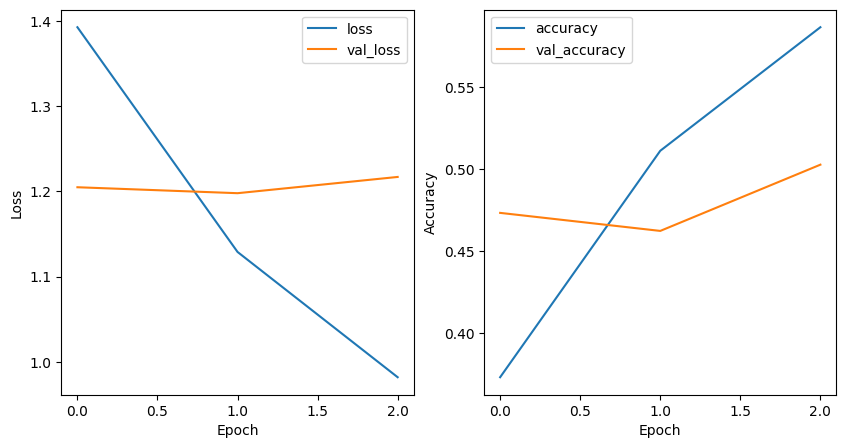

In [33]:
# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'],
         metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 277ms/step


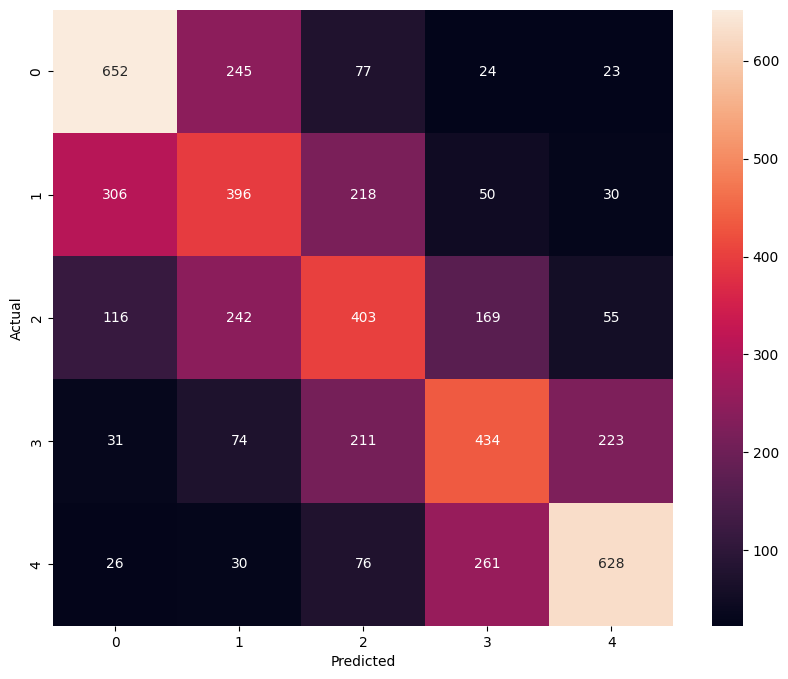

In [34]:
# converting y_test tht was one hot encoded to one column fo rconfusion matrix
y_true = np.argmax(y_test.values, axis=1)
y_true.shape

# Confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [35]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.58      0.64      0.61      1021
           1       0.40      0.40      0.40      1000
           2       0.41      0.41      0.41       985
           3       0.46      0.45      0.45       973
           4       0.65      0.62      0.63      1021

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



In [37]:
# Testing the trained model


In [36]:
def predict_review_rating(text):
  text_sequences_test = np.array(tokenizer.texts_to_sequences([text]))
  testing = pad_sequences(text_sequences_test, maxlen = max_words)
  y_pred_test = np.argmax(model.predict(testing), axis=1)
  return y_pred_test[0]+1

# Testing
rating1 = predict_review_rating('Worst product')
print("The rating according to the review is: ", rating1)

rating2 = predict_review_rating('Awesome product,  I will recommend this to other users.')
print("The rating according to the review is: ", rating2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
The rating according to the review is:  1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
The rating according to the review is:  5
